Image to text using salesforce blip

source: https://huggingface.co/Salesforce/blip-image-captioning-large

Need ```PIL``` and ```transformers```, which requieres ```pytorch``` and ```tensorflow```

In [10]:
import os
import pandas as pd

In [11]:
df_keys = pd.read_excel('../0_data/1_data_no_humans.xlsx')
df_keys.head()

,Key_path,Long,No_humans
0,../1_download_data/hm\2022-12-21_17-02-38_UTC\...,2022-12-21_17-02-38_UTC,0
1,../1_download_data/hm\2022-12-21_17-02-38_UTC\...,2022-12-21_17-02-38_UTC,0
2,../1_download_data/hm\2022-12-21_17-02-38_UTC\...,2022-12-21_17-02-38_UTC,0
3,../1_download_data/hm\2022-12-21_17-02-38_UTC\...,2022-12-21_17-02-38_UTC,0
4,../1_download_data/hm\2022-12-23_14-18-20_UTC\...,2022-12-23_14-18-20_UTC,0


In [12]:
jpg_files = list(df_keys['Key_path'])
len(jpg_files)

2800

### Blip tuned for captioning
https://huggingface.co/noamrot/FuseCap_Image_Captioning

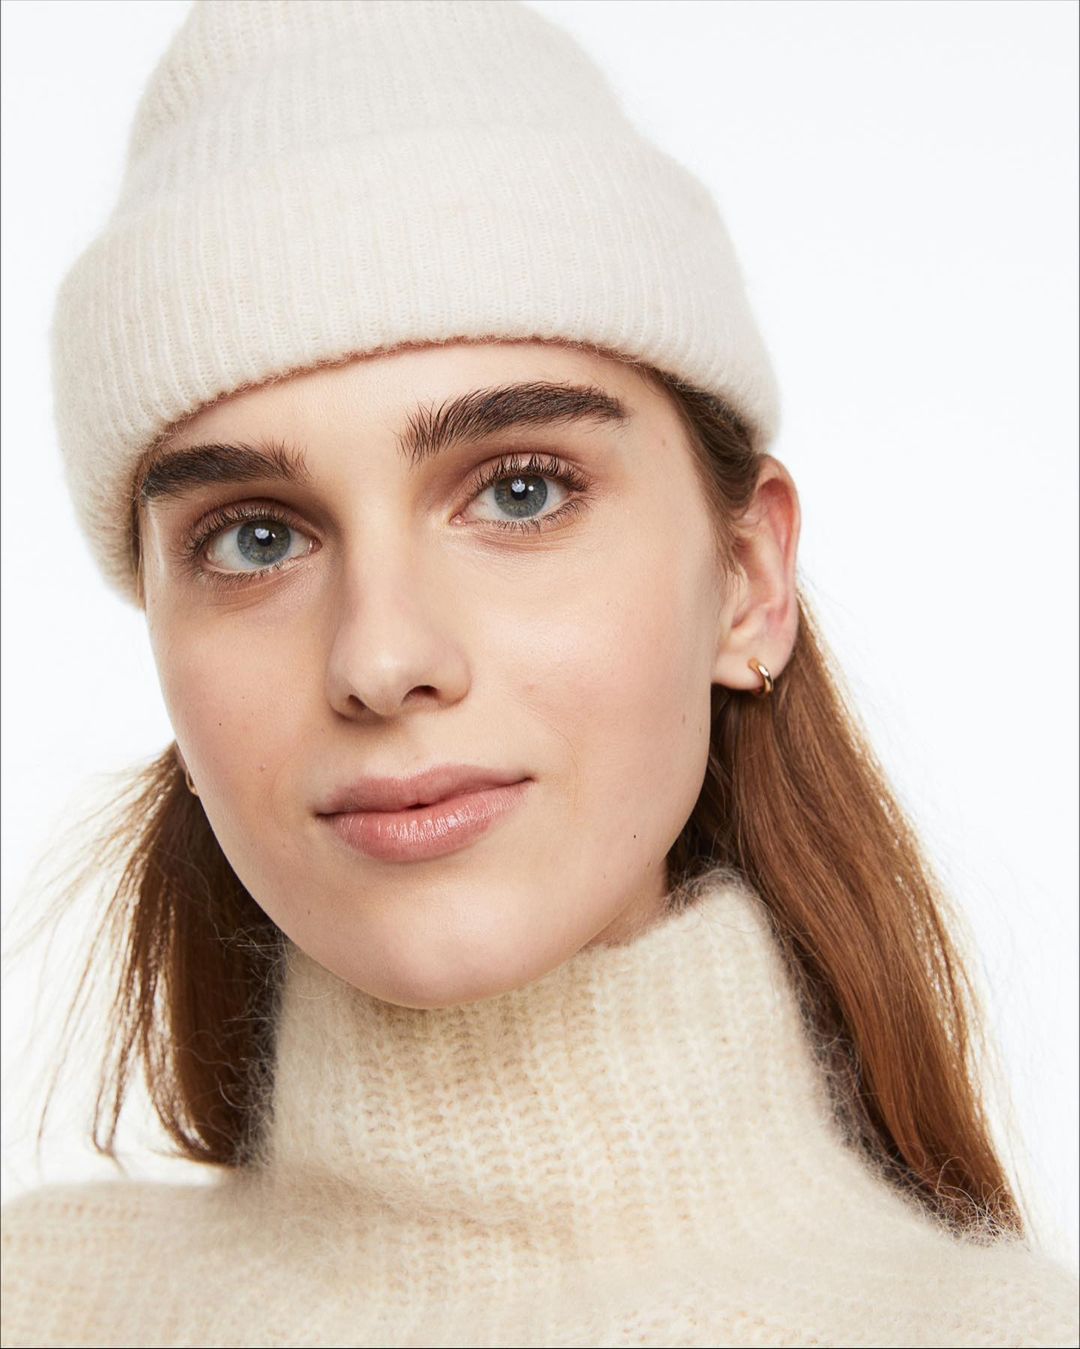

In [15]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = BlipProcessor.from_pretrained("noamrot/FuseCap")
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap").to(device)

image_path = jpg_files[1]
raw_image = Image.open(image_path).convert('RGB')
raw_image

In [16]:
text = "the picture contains"
inputs = processor(raw_image, text, return_tensors="pt").to(device)

out = model.generate(**inputs, num_beams = 3)
print(processor.decode(out[0], skip_special_tokens=True))

the picture contains a close - up of a woman's face wearing a white sweater and hat, with brown hair, eyebrows, and eyes, a small nose, and a pink ear visible


# Caption Images
Use the transformer model to caption each image and store the captions in a dictionary

Instead of all the images, pass only the images containing people

In [17]:
from PIL import Image, ImageFile
from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading of truncated images
dict_captions = {}
for image in tqdm(jpg_files[0:20]):
    try:
        with Image.open(image) as img:
            raw_image = img.convert('RGB')
            # Further processing of raw_image if needed
            # unconditional image captioning
            text = "the picture contains"
            inputs = processor(raw_image, text, return_tensors="pt").to(device)
            out = model.generate(**inputs, num_beams = 3)
            dict_captions[image] = processor.decode(out[0], skip_special_tokens=True)
    except IOError as e:
        print(f"Cannot process image {image}: {e}")
        dict_captions[image] = ''

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:34<00:00, 10.75s/it]


In [ ]:
import pandas as pd
df_captions =  pd.DataFrame(list(dict_captions.items()), columns=['Long', 'Auto_caption'])

In [ ]:
df_captions

In [ ]:
df_captions['Has_women'] = df_captions['Auto_caption'].str.contains('woman|women') # Create filter for caption with woman, women
df_women = df_captions[df_captions['Has_women'] == True].reset_index(drop = True) #filter implementation

In [ ]:
df_women.to_excel('../0_data/2_data_women.xlsx', index=False) #save for later cleaning, processing